# 05_WindForcing

Relation to large-scale patterns of atm. forcing

In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units

# path to own functions
sys.path.append('../../')
import timeseries.adjust as tseries
import geofunc.general as geogen
import geofunc.vectors as vectors
import geofunc.shapes as geoshape
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import data_NSIDC.icedrift as icedrift

In [2]:
def grab_atm(time_range, lat = 70.5 , lon = -140, dt = 'hourly'):

    def file_name(year, dt):
        if str(dt) == 'hourly':
            return f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{year}.nc'
        else:
            return f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc'
            
    if time_range.stop.year != time_range.start.year:
        
        # year1
        DS1 = xr.open_dataset(file_name(time_range.start.year, dt))
        DS1.close()
        time_slice = slice(time_range.start, datetime(time_range.start.year, 12, 31, 23))
        DS1 = DS1.sel(latitude = lat, longitude = lon, time=time_slice)
        
        # year2
        DS2 = xr.open_dataset(file_name(time_range.stop.year, dt))
        DS2.close()
        time_slice = slice(datetime(time_range.stop.year, 1, 1, 0), time_range.stop)
        DS2 = DS2.sel(latitude = lat, longitude = lon, time=time_slice)

        # combine
        dsm = xr.concat([DS1, DS2], dim="time")
    
    else:
        
        # year1
        dsm = xr.open_dataset(file_name(time_range.start.year, dt))
        dsm.close()
        time_slice = time_range
        dsm = dsm.sel(latitude = lat, longitude = lon, time=time_slice)
        
    return dsm
    

In [36]:
def open_hourly_winds(year, lat_range, lon_range, time_range = None):
    
    ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{year}.nc')
    ds.close()
    
    if 'valid_time' in list(ds.coords):
        ds = ds.rename({"valid_time": "time"})
    
    if time_range == None:
        ds = ds.sel(latitude = lat_range, longitude = lon_range)
    else:
        ds = ds.sel(time = time_range, latitude = lat_range, longitude = lon_range)
        
    return ds

def open_daily_winds(year, lat_range, lon_range, time_range = None):
    
    ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc')
    ds.close()
    if time_range == None:
        ds = ds.sel(latitude = lat_range, longitude = lon_range)
    else:
        ds = ds.sel(time = time_range, latitude = lat_range, longitude = lon_range)
        
    return ds

def open_daily_t2m(year, lat_range, lon_range, time_range = None):
    
    ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ERA5/daily_t2m/ERA5_T2m_daily_{year}.nc')
    ds.close()
    
    if time_range == None:
        ds = ds.sel(latitude = lat_range, longitude = lon_range)
    else:
        ds = ds.sel(valid_time = time_range, latitude = lat_range, longitude = lon_range)
    
    return ds


def open_daily_drift(year, lat_range, lon_range, time_range = None):
    
    if time_range == None:
        dates = pd.to_datetime(pd.date_range(datetime(year,1,1),datetime(year,12,31), freq='1D'))
    else:
        dates = pd.to_datetime(pd.date_range(time_range.start, time_range.stop, freq='1D'))
        
    drift = icedrift.open_local_file(dates, crop = [200,300,110,200],include_units = False)
    
    
    drift2 = {}
    drift2['u'] = drift['u']
    drift2['v'] = drift['v']
    drift2['e'] = drift['e']
    drift2['n'] = drift['n']
    drift2['error'] = drift['error']
    
    drift2['s'] = np.sqrt(drift['e']**2+drift['n']**2)

    return drift2



In [5]:
year = 2003
YEAR = year-1
month = 12
month_length = calendar.monthrange(YEAR, month)[1]
time_range = slice(datetime(YEAR,month,1), datetime(YEAR,month,month_length)) 
    
# dates = pd.to_datetime(pd.date_range(time_range.start, time_range.stop, freq='1D'))
# print(dates)
# drift = icedrift.open_local_file(dates, crop = [200,300,110,200],include_units = False)
drift2 = open_daily_drift(year, lat_range, lon_range, time_range = time_range)

NameError: name 'lat_range' is not defined

### Background fields (and regional data)

In [ ]:
year = date.year
ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc')
ds.close()
ds = ds.sel(time = date, latitude = lat_range, longitude = lon_range)
speed = np.sqrt(ds.u10**2+ds.v10**2)

u_event_sum += ds.u10.values
v_event_sum += ds.v10.values
s_event_sum += speed.values
m_event_sum += ds.msl.values/100

ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ERA5/daily_t2m/ERA5_T2m_daily_{year}.nc')
ds.close()
ds = ds.sel(valid_time = date, latitude = lat_range, longitude = lon_range)
t_event_sum += (ds.t2m - 273.15).values

event_counter+=1

In [6]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

## Reference grids

In [7]:
grids = {}

# ERA5
#-----
era_lat_range = slice(74,68)
era_lon_range = slice(-165,-125)
ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_2024_daily.nc')
ds.close()
ds = ds.sel(latitude = era_lat_range, longitude = era_lon_range)
longrid, latgrid = np.meshgrid(ds.longitude, ds.latitude)

grids['era'] = {}
grids['era']['lat'] = latgrid
grids['era']['lon'] = longrid


# PPD drift
#----------
drift = icedrift.open_local_file(datetime(2023,1,1), crop = [200,300,110,200],include_units = False)
drift['lon'][drift['lon']>180]-=360
grids['ppd'] = {}
grids['ppd']['lat'] = drift['lat']
grids['ppd']['lon'] = drift['lon']
grids['ppd']['xx'] = drift['xx']
grids['ppd']['yy'] = drift['yy']


# open regional bounding coordinates
df = pd.read_csv('../data/coastal_region_bounds_v5.csv')
reg_poly = geoshape.make_polygon(np.stack((df['lons'], df['lats']), axis=1))


from shapely.geometry import Point

for key in grids.keys():
    print(key)
    
    grids[key]['region'] = np.full(grids[key]['lon'].shape, False)

    for ii in range(np.shape(grids[key]['region'])[0]):
        for jj in range(np.shape(grids[key]['region'])[1]):

            lon, lat = grids[key]['lon'][ii,jj], grids[key]['lat'][ii,jj]
            if lon > 180:
                lon-=360

            if reg_poly.contains(Point(lon, lat)):
                grids[key]['region'][ii,jj] = True
                

era
ppd


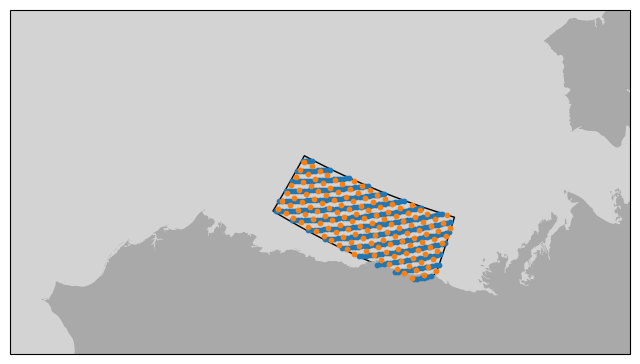

In [8]:

# initialize map
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))
ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-800000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None', crs=ccrs.PlateCarree())


for key in ['era', 'ppd']:
    ax.scatter(grids[key]['lon'][grids[key]['region']], grids[key]['lat'][grids[key]['region']], zorder=100, s = 10, transform=ccrs.PlateCarree())


## Hourly regional atm. forcing

In [9]:


years = np.arange(2003, 2026)
# years = [2023,2024,2025]



for year in years:
    
    era_vars = ['u10', 'v10', 'msl']

    hourly_data = {}
    for var in era_vars:
        hourly_data[var] = np.array([])

    all_dates = np.array([], dtype=np.datetime64)

    # Nov-Dec data
    #-------------
    dates = pd.date_range(datetime(year-1, 10,15), datetime(year-1, 12,31, 23), freq='1H')
    all_dates = np.append(all_dates, dates)
    ds = open_hourly_winds(year-1, era_lat_range, era_lon_range, time_range = slice(dates[0], dates[-1]))

    # loop over each hour
    for tt, time in enumerate(ds.time):

        if tt%500 == 0:
            print(tt, time.values)
        ds_crop = ds.sel(time = time)

        # find regional means
        for var in era_vars:
            reg_mean = geogen.lat_weighted_mean(ds_crop[var].values[grids['era']['region']], 
                                        grids['era']['lat'][grids['era']['region']])
            hourly_data[var] = np.append(hourly_data[var], reg_mean)

    # Jan-June data
    #-------------
    dates = pd.date_range(datetime(year, 1,1), datetime(year, 6,15, 23), freq='1H')
    all_dates = np.append(all_dates, dates)
    ds = open_hourly_winds(year, era_lat_range, era_lon_range, time_range = slice(dates[0], dates[-1]))

    # loop over each hour
    for tt, time in enumerate(ds.time):

        if tt%1000 == 0:
            print(tt, time.values)
        ds_crop = ds.sel(time = time)

        # find regional means
        for var in era_vars:
            reg_mean = geogen.lat_weighted_mean(ds_crop[var].values[grids['era']['region']], 
                                        grids['era']['lat'][grids['era']['region']])
            hourly_data[var] = np.append(hourly_data[var], reg_mean)
            
            
    key = 'era'
    data_vars = {}
    for var in era_vars:
        extra_nans = np.full(len(all_dates) - len(hourly_data[var]), np.nan)
        data_vars[var] = (("time"), np.append(hourly_data[var], extra_nans))
#         data_vars[var] = (("time"), hourly_data[var])

    coords={"time": all_dates}

    ds = xr.Dataset(data_vars, coords=coords)

    # save to file
    mainpath = '../data/forcing/'
    filename = f"regional_hourly_era_{year}_v0.nc"
    ds.to_netcdf(mainpath+filename)

0 2002-10-15T00:00:00.000000000
500 2002-11-04T20:00:00.000000000
1000 2002-11-25T16:00:00.000000000
1500 2002-12-16T12:00:00.000000000
0 2003-01-01T00:00:00.000000000
1000 2003-02-11T16:00:00.000000000
2000 2003-03-25T08:00:00.000000000
3000 2003-05-06T00:00:00.000000000
0 2003-10-15T00:00:00.000000000
500 2003-11-04T20:00:00.000000000
1000 2003-11-25T16:00:00.000000000
1500 2003-12-16T12:00:00.000000000
0 2004-01-01T00:00:00.000000000
1000 2004-02-11T16:00:00.000000000
2000 2004-03-24T08:00:00.000000000
3000 2004-05-05T00:00:00.000000000
4000 2004-06-15T16:00:00.000000000
0 2004-10-15T00:00:00.000000000
500 2004-11-04T20:00:00.000000000
1000 2004-11-25T16:00:00.000000000
1500 2004-12-16T12:00:00.000000000
0 2005-01-01T00:00:00.000000000
1000 2005-02-11T16:00:00.000000000
2000 2005-03-25T08:00:00.000000000
3000 2005-05-06T00:00:00.000000000
0 2005-10-15T00:00:00.000000000
500 2005-11-04T20:00:00.000000000
1000 2005-11-25T16:00:00.000000000
1500 2005-12-16T12:00:00.000000000
0 2006-01-

ValueError: conflicting sizes for dimension 'time': length 5856 on 'time' and length 3644 on {'time': 'u10'}

## Daily wind forcing

In [48]:

years = np.arange(2003, 2025)

years = [2025]

for year in years:
    
    era_vars = ['u10', 'v10', 's10', 'msl', 't2m', ]

    daily_data = {}
    for var in era_vars:
        daily_data[var] = np.array([])

    all_dates = np.array([], dtype=np.datetime64)

    # Nov-Dec data
    #-------------
    dates = pd.date_range(datetime(year-1, 11,1), datetime(year-1, 12,31, 23), freq='1D')
    all_dates = np.append(all_dates, dates)
    
    ds2 = open_daily_t2m(year-1, era_lat_range, era_lon_range,  time_range = slice(dates[0], dates[-1]))
    ds = open_daily_winds(year-1, era_lat_range, era_lon_range,  time_range = slice(dates[0], dates[-1]))
    
    # loop over each hour
    for tt, time in enumerate(ds.time):

        if tt%1000 == 0:
            print(tt, time.values)
        ds_crop = ds.sel(time = time)
        ds2_crop = ds2.sel(valid_time = time)
        
        # find regional means
        for var in ['u10', 'v10', 'msl']:
            reg_mean = geogen.lat_weighted_mean(ds_crop[var].values[grids['era']['region']], 
                                        grids['era']['lat'][grids['era']['region']])
            daily_data[var] = np.append(daily_data[var], reg_mean)
            
        for var in ['s10']:
            speeds = np.sqrt(ds_crop['u10'].values**2+ds_crop['v10'].values**2)
            reg_mean = geogen.lat_weighted_mean(speeds[grids['era']['region']], 
                                        grids['era']['lat'][grids['era']['region']])
            daily_data[var] = np.append(daily_data[var], reg_mean)
            
            
        for var in ['t2m']:
            reg_mean = geogen.lat_weighted_mean((ds2_crop[var]-273.15).values[grids['era']['region']], 
                                        grids['era']['lat'][grids['era']['region']])
            daily_data[var] = np.append(daily_data[var], reg_mean)
            
            
    # Jan-June data
    #-------------
    dates = pd.date_range(datetime(year, 1,1), datetime(year, 4,30, 23), freq='1D')
    all_dates = np.append(all_dates, dates)
    ds = open_daily_winds(year, era_lat_range, era_lon_range,  time_range = slice(dates[0], dates[-1]))
    ds2 = open_daily_t2m(year, era_lat_range, era_lon_range,  time_range = slice(dates[0], dates[-1]))
    
    # loop over each hour
    for tt, time in enumerate(ds.time):

        if tt%1000 == 0:
            print(tt, time.values)
        ds_crop = ds.sel(time = time)
        ds2_crop = ds2.sel(valid_time = time)
        
        # find regional means
        for var in ['u10', 'v10', 'msl']:
            reg_mean = geogen.lat_weighted_mean(ds_crop[var].values[grids['era']['region']], 
                                        grids['era']['lat'][grids['era']['region']])
            daily_data[var] = np.append(daily_data[var], reg_mean)
            
        for var in ['s10']:
            speeds = np.sqrt(ds_crop['u10'].values**2+ds_crop['v10'].values**2)
            reg_mean = geogen.lat_weighted_mean(speeds[grids['era']['region']], 
                                        grids['era']['lat'][grids['era']['region']])
            daily_data[var] = np.append(daily_data[var], reg_mean)
            
        for var in ['t2m']:
            reg_mean = geogen.lat_weighted_mean((ds2_crop[var]-273.15).values[grids['era']['region']], 
                                        grids['era']['lat'][grids['era']['region']])
            daily_data[var] = np.append(daily_data[var], reg_mean)
            
            
    key = 'era'
    data_vars = {}
    for var in era_vars:
        extra_nans = np.full(len(all_dates) - len(daily_data[var]), np.nan)
        data_vars[var] = (("time"), np.append(daily_data[var], extra_nans))
    #         data_vars[var] = (("time"), hourly_data[var])

    coords={"time": all_dates}

    ds = xr.Dataset(data_vars, coords=coords)

    # save to file
    mainpath = '../data/forcing/'
    filename = f"regional_daily_era_{year}_v0.nc"
    ds.to_netcdf(mainpath+filename)

0 2023-11-01T00:00:00.000000000
0 2024-01-01T00:00:00.000000000


PermissionError: [Errno 13] Permission denied: '/Users/mackenziejewell/Documents/GitHub/SBSpolynya/data/forcing/regional_daily_era_2024_v0.nc'

## Daily regional PPd drift

In [38]:


years = np.arange(2003, 2024)


for year in years:
    
    ppd_vars = ['e', 'n', 'error', 's']

    daily_data = {}
    for var in ppd_vars:
        daily_data[var] = np.array([])

    all_dates = np.array([], dtype=np.datetime64)

    # Nov-Dec data
    #-------------
    dates = pd.date_range(datetime(year-1, 10,15), datetime(year-1, 12,31, 23), freq='1D')
    all_dates = np.append(all_dates, dates)
    ds = open_daily_drift(year-1, era_lat_range, era_lon_range,  time_range = slice(dates[0], dates[-1]))
    
    
    # loop over each hour
    for tt in range(len(ds['e'])):

        if tt%100 == 0:
            print(tt)
        # find regional means
        for var in ppd_vars:
            
            reg_mean = np.nanmean(ds[var][tt,:,:][grids['ppd']['region']])
            daily_data[var] = np.append(daily_data[var], reg_mean)

    # Jan-June data
    #-------------
    dates = pd.date_range(datetime(year, 1,1), datetime(year, 6,15, 23), freq='1D')
    all_dates = np.append(all_dates, dates)
    ds = open_daily_drift(year, era_lat_range, era_lon_range,  time_range = slice(dates[0], dates[-1]))

    # loop over each hour
    for tt in range(len(ds['e'])):

        # find regional means
        for var in ppd_vars:
            
            reg_mean = np.nanmean(ds[var][tt,:,:][grids['ppd']['region']])
            daily_data[var] = np.append(daily_data[var], reg_mean)
            
            
    key = 'ppd'
    data_vars = {}
    for var in ppd_vars:
        extra_nans = np.full(len(all_dates) - len(daily_data[var]), np.nan)
        data_vars[var] = (("time"), np.append(daily_data[var], extra_nans))
    #         data_vars[var] = (("time"), hourly_data[var])

    coords={"time": all_dates}

    ds = xr.Dataset(data_vars, coords=coords)

    # save to file
    mainpath = '../data/forcing/'
    filename = f"regional_daily_ppd_{year}_v0.nc"
    ds.to_netcdf(mainpath+filename)

0
0
0
0
0


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_29788/1065213828.py:29: RuntimeWarning: Mean of empty slice
  reg_mean = np.nanmean(ds[var][tt,:,:][grids['ppd']['region']])


0
0
0
0
0


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_29788/1065213828.py:29: RuntimeWarning: Mean of empty slice
  reg_mean = np.nanmean(ds[var][tt,:,:][grids['ppd']['region']])


0


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_29788/1065213828.py:29: RuntimeWarning: Mean of empty slice
  reg_mean = np.nanmean(ds[var][tt,:,:][grids['ppd']['region']])


0
0
0
0


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_29788/1065213828.py:29: RuntimeWarning: Mean of empty slice
  reg_mean = np.nanmean(ds[var][tt,:,:][grids['ppd']['region']])


0


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_29788/1065213828.py:29: RuntimeWarning: Mean of empty slice
  reg_mean = np.nanmean(ds[var][tt,:,:][grids['ppd']['region']])


0
0


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_29788/1065213828.py:29: RuntimeWarning: Mean of empty slice
  reg_mean = np.nanmean(ds[var][tt,:,:][grids['ppd']['region']])


0


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_29788/1065213828.py:29: RuntimeWarning: Mean of empty slice
  reg_mean = np.nanmean(ds[var][tt,:,:][grids['ppd']['region']])


0


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_29788/1065213828.py:29: RuntimeWarning: Mean of empty slice
  reg_mean = np.nanmean(ds[var][tt,:,:][grids['ppd']['region']])


0


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_29788/1065213828.py:29: RuntimeWarning: Mean of empty slice
  reg_mean = np.nanmean(ds[var][tt,:,:][grids['ppd']['region']])


In [584]:

field = {}

reg = {}

GROUPS = {}
GROUPS['era'] = ['u10', 'v10', 'msl', 't2m', 's10']
GROUPS['ppd'] = ['e', 'n','s']
months = [12, 1, 2, 3, 4]
YEARS = years

for key in ['era', 'ppd']:
    
    # whole maps
    field[key] = {}

    # regional means
    reg[key] = {}
    regmonth[key] = {}
    regyear[key] = {}

    for group in GROUPS[key]:
        
        field[key][group] = {}
        
        reg[key][group] = {}
        
        for month in months:
            field[key][group][month] = {}
            reg[key][group][month] = {}
            
            for year in YEARS:
                field[key][group][month][year] = {}
                field[key][group][month][year]['sum'] = np.zeros(grids[key]['lon'].shape)
                field[key][group][month][year]['N'] = np.zeros(grids[key]['lon'].shape)
                reg[key][group][month][year] = np.array([])


# build dictionary 
for year in YEARS:

    print(year)
    
    # January - April
    #-----------------
    for month in months:

        if month == 12:
            YEAR = year - 1
        else:
            YEAR = year
            
        # open files
        month_length = calendar.monthrange(YEAR, month)[1]
        time_range = slice(datetime(YEAR,month,1), datetime(YEAR,month,month_length))        
        ds = open_daily_winds(YEAR, era_lat_range, era_lon_range, time_range=time_range)
        ds2 = open_daily_t2m(YEAR, era_lat_range, era_lon_range, time_range=time_range)
        
        if year != 2024:
            d3 = open_daily_drift(YEAR, lat_range, lon_range, time_range = time_range)
        else:
            d3 = {}
            for group in GROUPS[key]:
                d3[group] = np.full((month_length, 100, 90), np.nan)
        
        # atmosphere
        #-----------------
        key = 'era'
        reg_pts = grids[key]['region']
        for group in GROUPS[key]:
            
            dicts = field[key][group][month][year]

            if group == 't2m':
                dicts['sum'] += (ds2[group]-273.15).sum(dim='valid_time').values
                dicts['N'] += np.isfinite(ds2[group]).sum(dim='valid_time').values
            elif group == 's10':
                dicts['sum'] += np.sqrt(ds['u10']**2+ds['v10']**2).sum(dim='time').values
                dicts['N'] += np.isfinite(ds['u10']).sum(dim='time').values
            else:
                dicts['sum'] += ds[group].sum(dim='time').values
                dicts['N'] += np.isfinite(ds[group]).sum(dim='time').values
                    
            # save regional means
            for time in ds.time:
                
                if group == 't2m':
                    reg_values = (ds2[group]-273.15).sel(valid_time = time).values[reg_pts]
                elif group == 's10':
                    reg_values = np.sqrt(ds['u10']**2+ds['v10']**2).sel(time = time).values[reg_pts]
                else:
                    reg_values = ds[group].sel(time = time).values[reg_pts]
                
                reg_mean = geogen.lat_weighted_mean(reg_values, grids[key]['lat'][reg_pts])
                reg[key][group][month][year] = np.append(reg[key][group][month][year], reg_mean)

        
        # sea ice drift
        #-----------------
        key = 'ppd'
        reg_pts = grids[key]['region']
        for group in GROUPS[key]:
            
            dicts = field[key][group][month][year]
            dicts['sum'] += np.nansum(d3[group], axis=0)
            dicts['N'] += np.nansum(np.isfinite(d3[group]), axis=0)
                    
            # save regional means
            for ii in range(len(d3['e'])):
                reg_mean = np.nanmean(d3[group][ii][reg_pts])
                reg[key][group][month][year] = np.append(reg[key][group][month][year], reg_mean)

# calculate means!
#-----------------
for key in ['era', 'ppd']:
    for group in GROUPS[key]:
        for month in months:
            for year in YEARS:
                field[key][group][month][year]['mean'] = field[key][group][month][year]['sum'] / field[key][group][month][year]['N']


2003
2004
2005
2006
2007
2008
2009
2010
2011
2013
2014
2015
2016
2017
2018
2019
2020
2021


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_16386/1981190657.py:109: RuntimeWarning: Mean of empty slice
  reg_mean = np.nanmean(d3[group][ii][reg_pts])


2022


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_16386/1981190657.py:109: RuntimeWarning: Mean of empty slice
  reg_mean = np.nanmean(d3[group][ii][reg_pts])


2023
2024


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_16386/1981190657.py:109: RuntimeWarning: Mean of empty slice
  reg_mean = np.nanmean(d3[group][ii][reg_pts])
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_16386/1981190657.py:109: RuntimeWarning: Mean of empty slice
  reg_mean = np.nanmean(d3[group][ii][reg_pts])
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_16386/1981190657.py:109: RuntimeWarning: Mean of empty slice
  reg_mean = np.nanmean(d3[group][ii][reg_pts])
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_16386/1981190657.py:109: RuntimeWarning: Mean of empty slice
  reg_mean = np.nanmean(d3[group][ii][reg_pts])
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_16386/1981190657.py:109: RuntimeWarning: Mean of empty slice
  reg_mean = np.nanmean(d3[group][ii][reg_pts])
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_16386/1981190657.py:118: RuntimeWarning: invalid value encountered in divide
  field[key][group][mont

## Save to nc


#### ERA map

In [585]:
key = 'era'

data_vars = {}

for group in list(field[key].keys()):
    
    # stack data
    stacked = np.array([])
    for month in months:
        for year in YEARS:
            stacked = np.append(stacked, field[key][group][month][year]['mean'])
    stacked = np.reshape(stacked, (len(months),len(YEARS),*grids[key]['lat'].shape))

    # construct data field
    data_vars[group] = (("month", "year", "lat", "lon"), stacked)#, {'long_name': long_name, 'units': units})

coords={"month": months, "year": YEARS, "lat":grids[key]['lat'][:,0], "lon":grids[key]['lon'][0,:]}

ds = xr.Dataset(data_vars, coords=coords)   

# save to file
mainpath = '../data/forcing/'
filename = f"dailymaps_{key}_v0.nc"
ds.to_netcdf(mainpath+filename)


#### PPD map

In [586]:
key = 'ppd'

data_vars = {}

for group in list(field[key].keys()):
    
    # stack data
    stacked = np.array([])
    for month in months:
        for year in YEARS:
            stacked = np.append(stacked, field[key][group][month][year]['mean'])
    stacked = np.reshape(stacked, (len(months),len(YEARS),*grids[key]['lat'].shape))

    # construct data field
    data_vars[group] = (("month", "year", "y", "x"), stacked)#, {'long_name': long_name, 'units': units})

coords={"month": months, "year": YEARS, "x":grids[key]['xx'][0,:], "y":grids[key]['yy'][:,0]}

ds = xr.Dataset(data_vars, coords=coords)   

# save to file
mainpath = '../data/forcing/'
filename = f"dailymaps_{key}_v0.nc"
ds.to_netcdf(mainpath+filename)


#### ERA region stats

In [587]:
key = 'era'

data_vars = {}

for group in list(reg[key].keys()):
    
    # stack data
    stacked = np.array([])
    stacked_dates = np.array([])
    
    for month in months:
        for year in YEARS:
            
            monthlydata = reg[key][group][month][year]
            fillto31 = np.append(monthlydata, np.full(31-len(monthlydata), np.nan))
            stacked = np.append(stacked, fillto31)
            
            if month == 12:
                YEAR = year-1
            else:
                YEAR = year
            for day in range(1,32):
                if day <= calendar.monthrange(YEAR, month)[1]:
                    stacked_dates = np.append(stacked_dates, datetime(YEAR, month, day))
                else:
                    stacked_dates = np.append(stacked_dates, np.nan)
            
    stacked = np.reshape(stacked, (len(months),len(YEARS), 31))
    stacked_dates = np.reshape(stacked_dates, (len(months),len(YEARS), 31))

    # construct data field
    data_vars[group] = (("month", "year", "day"), stacked)
    
data_vars['date'] = (("month", "year", "day"), stacked_dates)

coords={"month": months, "year": YEARS, "day" : np.arange(1,32)}

ds = xr.Dataset(data_vars, coords=coords)

# save to file
mainpath = '../data/forcing/'
filename = f"regional_{key}_v0.nc"
ds.to_netcdf(mainpath+filename)

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:618: RuntimeWarning: invalid value encountered in cast
  int_num = np.asarray(num, dtype=np.int64)


#### PPD region stats

In [588]:
key = 'ppd'

data_vars = {}

for group in list(reg[key].keys()):
    
    # stack data
    stacked = np.array([])
    stacked_dates = np.array([])
    
    for month in months:
        for year in YEARS:
            
            monthlydata = reg[key][group][month][year]
            fillto31 = np.append(monthlydata, np.full(31-len(monthlydata), np.nan))
            stacked = np.append(stacked, fillto31)
            
            if month == 12:
                YEAR = year-1
            else:
                YEAR = year
            for day in range(1,32):
                if day <= calendar.monthrange(YEAR, month)[1]:
                    stacked_dates = np.append(stacked_dates, datetime(YEAR, month, day))
                else:
                    stacked_dates = np.append(stacked_dates, np.nan)
            
    stacked = np.reshape(stacked, (len(months),len(YEARS), 31))
    stacked_dates = np.reshape(stacked_dates, (len(months),len(YEARS), 31))

    # construct data field
    data_vars[group] = (("month", "year", "day"), stacked)
    
data_vars['date'] = (("month", "year", "day"), stacked_dates)

coords={"month": months, "year": YEARS, "day" : np.arange(1,32)}

ds = xr.Dataset(data_vars, coords=coords)

# save to file
mainpath = '../data/forcing/'
filename = f"regional_{key}_v0.nc"
ds.to_netcdf(mainpath+filename)

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:618: RuntimeWarning: invalid value encountered in cast
  int_num = np.asarray(num, dtype=np.int64)


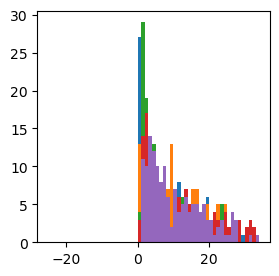

In [344]:
fig, ax = plt.subplots(figsize=(3,3))

bins = np.arange(-25,35,1)

key = 'ppd'
var = 's'


for year in [2003,2008,2013,2018,2023]:

    plt.hist(regyear[key][var][year], bins=bins)
#     # plt.hist(regmonth[key][var][1], bins=bins)
#     plt.hist(regmonth[key][var][2], bins=bins)
#     # plt.hist(regmonth[key][var][3], bins=bins)
#     plt.hist(regmonth[key][var][4], bins=bins)


In [590]:
123.2 - 90

33.2

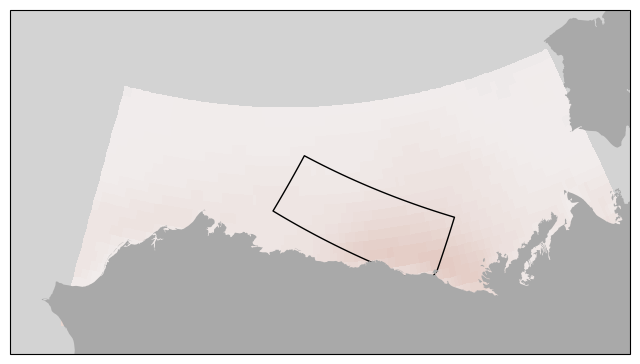

In [345]:

# initialize map
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))
ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-800000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None', crs=ccrs.PlateCarree())



# ax.pcolormesh(grids[key]['lon'], 
#               grids[key]['lat'], 
#               fieldmonth[key]['t2m'][4]['mean'], vmin=-40, vmax=-10, transform=ccrs.PlateCarree())


# key = 'era'
# ax.pcolormesh(grids[key]['lon'], 
#               grids[key]['lat'], 
#               fieldmonth[key]['t2m'][3]['mean'] - field[key]['t2m']['mean'], vmin=-10, vmax=10, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())



# key = 'ppd'
# ax.pcolormesh(grids[key]['lon'], 
#               grids[key]['lat'], 
#               fieldmonth[key]['s'][4]['mean'] - field[key]['s']['mean'], vmin=-10, vmax=10, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())


key = 'era'
ax.pcolormesh(grids[key]['lon'], 
              grids[key]['lat'], 
              fieldmonth[key]['s10'][1]['mean'] - field[key]['s10']['mean'], vmin=-5, vmax=5, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())
